# Lab 6: Association Rule Mining with Apriori and FP-Growth
**Name:** Mohit Gokul Murali  
**Course:** Advanced Big Data and Data Mining (MSCS-634-B01)  
**Date:** Nov 30, 2025


## Step 1: Data Preparation
Load the dataset, clean it, and prepare it for association rule mining. Visualize the dataset to understand item frequency and co-occurrence patterns.


In [8]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

# Set Seaborn style
sns.set(style="whitegrid")


In [9]:
# Load Online Retail dataset directly from UCI repository
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'

# Read Excel file
df = pd.read_excel(url)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [10]:
# Remove rows with missing InvoiceNo, Description, or Quantity
df = df.dropna(subset=['InvoiceNo', 'Description', 'Quantity'])

# Convert InvoiceNo to string (fixes TypeError with .str.contains)
df['InvoiceNo'] = df['InvoiceNo'].astype(str)

# Remove cancelled transactions (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].str.contains('C')]

# Keep only positive quantities
df = df[df['Quantity'] > 0]

# Reset index
df.reset_index(drop=True, inplace=True)

# Preview cleaned dataset
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


C:\Users\mohit\AppData\Local\Temp\ipykernel_10564\2628964834.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


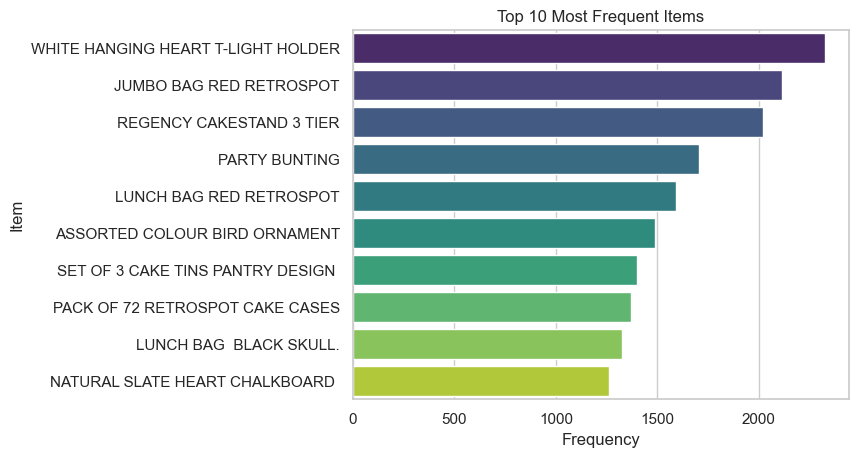

In [11]:
# Top 10 most frequent items
top_items = df['Description'].value_counts().head(10)

# Barplot of top items
sns.barplot(
    x=top_items.values, 
    y=top_items.index, 
    palette='viridis',
    dodge=False  # fixes Seaborn FutureWarning
)
plt.title('Top 10 Most Frequent Items')
plt.xlabel('Frequency')
plt.ylabel('Item')
plt.show()


In [12]:
# Create transaction-item matrix
basket = df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)

# Convert to boolean for mlxtend (True if item purchased, False otherwise)
basket_bool = (basket > 0)

# Preview boolean transaction matrix
basket_bool.head()

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,returned,taig adjust,test,to push order througha s stock was,website fixed,wrongly coded 20713,wrongly coded 23343,wrongly marked,wrongly marked 23343,wrongly sold (22719) barcode
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536366,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536367,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536368,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536369,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Step 2: Frequent Itemset Mining Using Apriori
Use Apriori to find frequent itemsets. Visualize top itemsets for insight.


In [13]:
# Apriori algorithm with minimum support 0.02
frequent_itemsets_apriori = apriori(
    basket_bool,
    min_support=0.02,
    use_colnames=True
)

# Sort by support
frequent_itemsets_apriori = frequent_itemsets_apriori.sort_values('support', ascending=False)

# Display top 10 frequent itemsets
frequent_itemsets_apriori.head(10)


,support,itemsets
273,0.112237,(WHITE HANGING HEART T-LIGHT HOLDER)
102,0.103894,(JUMBO BAG RED RETROSPOT)
197,0.098778,(REGENCY CAKESTAND 3 TIER)
157,0.083731,(PARTY BUNTING)
127,0.077672,(LUNCH BAG RED RETROSPOT)
15,0.072259,(ASSORTED COLOUR BIRD ORNAMENT)
218,0.068782,(SET OF 3 CAKE TINS PANTRY DESIGN )
149,0.065554,(PACK OF 72 RETROSPOT CAKE CASES)
120,0.063220,(LUNCH BAG BLACK SKULL.)
139,0.062028,(NATURAL SLATE HEART CHALKBOARD )


C:\Users\mohit\AppData\Local\Temp\ipykernel_10564\3251869532.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


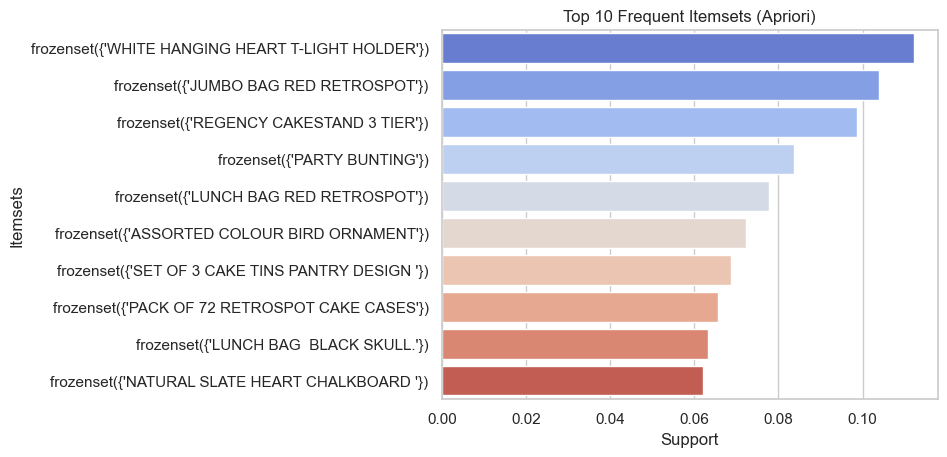

In [15]:
# Top 10 Apriori frequent itemsets visualization
top_apriori = frequent_itemsets_apriori.head(10)

sns.barplot(
    x='support',
    y='itemsets',
    data=top_apriori.assign(itemsets=top_apriori['itemsets'].astype(str)),  # convert to string in DataFrame
    palette='coolwarm',
    dodge=False
)
plt.title('Top 10 Frequent Itemsets (Apriori)')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.show()


## Step 3: Frequent Itemset Mining Using FP-Growth
FP-Growth is faster than Apriori for larger datasets. Compare results.


In [16]:
# Measure FP-Growth runtime
start_time = time.time()
frequent_itemsets_fp = fpgrowth(
    basket_bool,
    min_support=0.02,
    use_colnames=True
)
fp_runtime = time.time() - start_time
print(f"FP-Growth runtime: {fp_runtime:.4f} seconds")

# Sort by support
frequent_itemsets_fp = frequent_itemsets_fp.sort_values('support', ascending=False)

# Display top 10 frequent itemsets
frequent_itemsets_fp.head(10)

FP-Growth runtime: 11.6871 seconds


,support,itemsets
0,0.112237,(WHITE HANGING HEART T-LIGHT HOLDER)
66,0.103894,(JUMBO BAG RED RETROSPOT)
162,0.098778,(REGENCY CAKESTAND 3 TIER)
232,0.083731,(PARTY BUNTING)
29,0.077672,(LUNCH BAG RED RETROSPOT)
4,0.072259,(ASSORTED COLOUR BIRD ORNAMENT)
243,0.068782,(SET OF 3 CAKE TINS PANTRY DESIGN )
30,0.065554,(PACK OF 72 RETROSPOT CAKE CASES)
107,0.063220,(LUNCH BAG BLACK SKULL.)
56,0.062028,(NATURAL SLATE HEART CHALKBOARD )


C:\Users\mohit\AppData\Local\Temp\ipykernel_10564\592602155.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


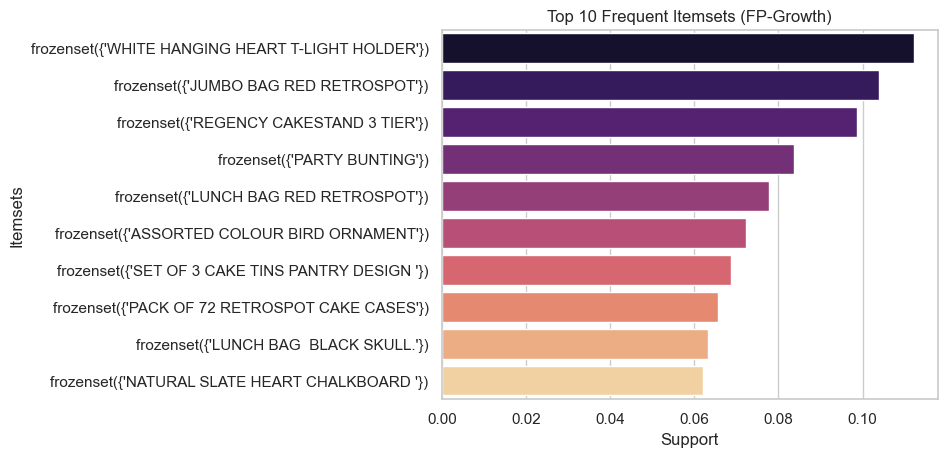

In [23]:
# Top 10 FP-Growth frequent itemsets
top_fp = frequent_itemsets_fp.head(10).copy()

# Convert 'itemsets' to string inside the DataFrame
top_fp['itemsets_str'] = top_fp['itemsets'].astype(str)

# Use Seaborn barplot with 'data='
sns.barplot(
    x='support',
    y='itemsets_str',
    data=top_fp,       # Pass the DataFrame
    palette='magma',
    dodge=False
)
plt.title('Top 10 Frequent Itemsets (FP-Growth)')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.show()

## Step 4: Generating and Analyzing Association Rules
Generate rules using a confidence threshold and analyze support, confidence, and lift.

In [24]:
# Association rules from Apriori frequent itemsets
rules_apriori = association_rules(
    frequent_itemsets_apriori,
    metric='confidence',
    min_threshold=0.5
)

# Sort by lift
rules_apriori = rules_apriori.sort_values('lift', ascending=False)

# Display top 10 rules
rules_apriori.head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
22,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",0.038041,0.038141,0.026917,0.707572,18.551648,1.0,0.025466,3.289215,0.983510,0.546371,0.695976,0.706650
21,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",(PINK REGENCY TEACUP AND SAUCER),0.038141,0.038041,0.026917,0.705729,18.551648,1.0,0.025466,3.268957,0.983612,0.546371,0.694092,0.706650
20,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.029748,0.050407,0.026917,0.904841,17.950627,1.0,0.025417,9.979054,0.973243,0.505597,0.899790,0.719416
23,(GREEN REGENCY TEACUP AND SAUCER),"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",0.050407,0.029748,0.026917,0.533990,17.950627,1.0,0.025417,2.082042,0.994417,0.505597,0.519702,0.719416
8,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.038041,0.050407,0.031436,0.826371,16.393893,1.0,0.029519,5.469083,0.976135,0.551394,0.817154,0.725008
9,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.050407,0.038041,0.031436,0.623645,16.393893,1.0,0.029519,2.555990,0.988847,0.551394,0.608762,0.725008
24,(ROSES REGENCY TEACUP AND SAUCER ),"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",0.052940,0.031436,0.026917,0.508443,16.173782,1.0,0.025253,1.970399,0.990615,0.468453,0.492489,0.682341
19,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.031436,0.052940,0.026917,0.856240,16.173782,1.0,0.025253,6.587791,0.968621,0.468453,0.848204,0.682341
18,(GARDENERS KNEELING PAD KEEP CALM ),(GARDENERS KNEELING PAD CUP OF TEA ),0.045342,0.037644,0.027116,0.598028,15.886413,1.0,0.025409,2.394090,0.981559,0.485333,0.582305,0.659173
17,(GARDENERS KNEELING PAD CUP OF TEA ),(GARDENERS KNEELING PAD KEEP CALM ),0.037644,0.045342,0.027116,0.720317,15.886413,1.0,0.025409,3.413354,0.973707,0.485333,0.707033,0.659173


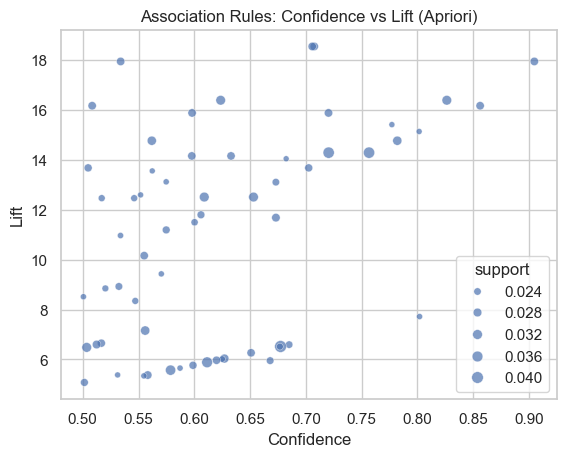

In [25]:
# Scatter plot: confidence vs lift
sns.scatterplot(
    x='confidence',
    y='lift',
    size='support',
    data=rules_apriori,
    alpha=0.7
)
plt.title('Association Rules: Confidence vs Lift (Apriori)')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.show()


## Step 5: Comparative Analysis
Compare Apriori and FP-Growth runtimes and output. Discuss observations and challenges.


In [26]:
# Measure Apriori runtime
start_time = time.time()
apriori(basket_bool, min_support=0.02, use_colnames=True)
apriori_runtime = time.time() - start_time
print(f"Apriori runtime: {apriori_runtime:.4f} seconds")

Apriori runtime: 22.8493 seconds


### Observations:
- FP-Growth is faster than Apriori for larger datasets.
- Both algorithms produce the same frequent itemsets when using the same support threshold.
- Converting the transaction matrix to boolean avoids mlxtend warnings and improves performance.
- Data cleaning is critical to remove cancelled transactions and negative quantities.
- Visualizations help quickly identify meaningful patterns in frequent items and association rules.
